<a href="https://colab.research.google.com/github/spoupry/Hello-world/blob/main/Aggregators_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import librairy

In [4]:
import pandas as pd
from pathlib import Path
import os.path
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg


from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Colab Notebooks/'
#pour les dates
from datetime import datetime, timedelta
from dateutil.parser import parse

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading database and parse data as columns index

In [ ]:
# Loading data from csv file
# daily PM10
df = pd.read_csv(dir_path + "pm10_daily.csv", delimiter="\t")
# print(df.head(2))
# deploiement
# df = pd.read_csv(dir_path + "deploiement.csv", delimiter=";")
# print(df.head(10))

# Parse date
df["DateTime"] = pd.to_datetime(df["DateTime"]) 
# df.head(2)
# initialisation dataset
#Setting the timestamp as index of the dataframe. 
df.set_index('DateTime', inplace=True) #DateTime is now the index. 
df.head()

# Initialisation

In [83]:
# Initialisation variables
StartTime_df = df.index[0]  # Starting timestamp dataset
EndTime_df = df.index[-1]   # End timestamp dataset
tau = timedelta(minutes=10) # step size for rolling window
StepTime = StartTime_df + tau  #slice of time
Threshold = 35 #  15% bonds for outliers
# Serie for raw datas for graphics
X1raw = pd.Series( [0] , index = [StartTime_df], dtype=float) 
X2raw = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3raw = pd.Series( [0] , index = [StartTime_df], dtype=float)
# print("Start df",StartTime_df,"End df",EndTime_df,"step",StepTime)
# Initialise global series (4)
# Median for row datas
Median = pd.DataFrame( index = [StartTime_df], columns=['Median','MedMax','MedMin'],dtype=float)
# Output after median voter
Outagg = pd.Series([0], index = [StartTime_df], dtype=float)
# Alert from no data detection
Alert = pd.Series( ['Begin'] , index = [StartTime_df])
# Outliers series corresponding SmS
X1out = pd.Series( [0] , index = [StartTime_df], dtype=float)
X2out = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3out = pd.Series( [0] , index = [StartTime_df], dtype=float)
# Reliable series extracted from Median 
X1r = pd.Series( [0] , index = [StartTime_df], dtype=float)
X2r = pd.Series( [0] , index = [StartTime_df], dtype=float)
X3r = pd.Series( [0] , index = [StartTime_df], dtype=float)

# Functions

In [11]:
# calculate the median of a serie
# Input : serie
# Output the median as a float or None if list =[]
def calculate_median(l):
    l = sorted(l)
    l_len = len(l)
    if l_len < 1:
        return None
    if l_len % 2 == 0 :
        return ( l[(l_len)//2] + l[(l_len//2)-1] ) / 2.0
    else:
        return l[(l_len-1)//2]

# l = [1,2,3,4,5,6]
# print(calculate_median(l))

In [12]:
# Dectect Hardware fault
# Input: 3 series of a slice
# No Output 
# Store data in Alert global serie
def detect_no_data(X1,X2,X3):
    #detection no Data
    # print("Start detection hardware fault")
    HardwareFault=[]
    #print("size of series X1,X2,X3 =",len(X1),len(X2),len(X3))
    if (len(X1) == 0): 
      #print("Hardware fault SmS1")
      HardwareFault.append("Hardware Fault SmS1")
    if (len(X2) == 0): 
      #print("Hardware fault SmS2")
      HardwareFault.append("Hardware Fault SmS2")
    if (len(X3) == 0): 
      #print("Hardware fault SmS3")
      HardwareFault.append("Hardware Fault SmS3")
    if (len(HardwareFault) == 0):
      print("All sensors is ok")
    else:
      print(HardwareFault," Ic= ", 3 - len(Alert.loc[StepTime]),"/3")     
    #Store Hardware fault in Alert serie
    Alert.loc[StepTime] = HardwareFault
    # print("End detection hardware fault")

In [13]:
# Dectect outlier from median and threshold
# Input: 3 series of a slice and a concatenated list of the 3 series
# Output 3 series Xrl of reliable values for filtering
# Store in Xr global series for later processing
def detect_outliers(X1,X2,X3,Concat):
    # print("Start ouliers detection & store")
    #evaluate median and calculate MedMax and MedMin for outlier detection
    Median_slice = calculate_median(Concat)
    # print(calculate_median(Concat))
    MedMin = Median_slice - (Median_slice*Threshold)/100
    MedMax = Median_slice + (Median_slice*Threshold)/100
    #store median for graphics in Median serie
    Median.loc[StepTime,'Median'] = Median_slice 
    Median.loc[StepTime,'MedMin'] = MedMin 
    Median.loc[StepTime,'MedMax'] = MedMax 
    # print("Median",Median_slice,"MedMin",MedMin,"MedMax",MedMax)
    #sOutputs function: X reliable data series
    X1rl = [] 
    X2rl = []
    X3rl = []
    idx_1rl= []      
    idx_2rl= [] 
    idx_3rl= [] 
    # Outliers and reliable of X1
    if(len(X1) != 0):     
      for time, row in X1.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X1out.loc[time] = row 
        else:
          X1r.loc[time] = row #store in global X1r serie for graphics
          X1rl.append(row)    
          idx_1rl.append(time)
    # print(X1)
    # print(X1out)
    # print(X1r)
    # Outliers and reliable of X2
    if(len(X2) != 0):
      for time, row in X2.iteritems():
          if((row > MedMax) or (row < MedMin)):
            X2out.loc[time] = row 
          else:
            X2r.loc[time] = row #store in global X1r serie for graphics
            X2rl.append(row)   
            idx_2rl.append(time)
    # print(X2)
    # print(X2out)
    # print(X2r)
    # Outliers and reliable of X3
    if(len(X3) != 0):
      for time, row in X3.iteritems():
        if((row > MedMax) or (row < MedMin)):
          X3out.loc[time] = row 
        else:
          X3r.loc[time] = row #store in global X1r serie for graphics
          X3rl.append(row)   
          idx_3rl.append(time)
    # print(X3)
    # print(X3out)
    # print(X3r)
    # construct series from lists
    X1rl = pd.Series(X1rl, index = idx_1rl, dtype=float)
    X2rl = pd.Series(X2rl, index = idx_2rl, dtype=float)
    X3rl = pd.Series(X3rl, index = idx_3rl, dtype=float)
    # print("End outliers detection & store")
    return X1rl,X2rl,X3rl

In [14]:
# Smoothing curve by apply kerbel regression
# Input: 3 series Xrl of reliable values
# Output 3 series Xf filtrated for median voter
def filtering(X1,X2,X3):
  from numpy import linspace
  # print("Start filtering")
  #X1
  # Must have two points minimum
  if(len(X1) == 0 or len(X1) == 1):
    X1f = X1
    print("not enough data")
  else:
    X1_ = X1.copy()
    X1_.index = linspace(1., len(X1_),len(X1_))
    kr = KernelReg([X1_.values],[X1_.index.values], var_type='c')
    f1 = kr.fit([X1_.index.values])
    X1f = pd.Series(data=f1[0], index = X1.index, dtype=float)
  #X2
  # Must have two points minimum
  if(len(X2) == 0 or len(X2) == 1):
    X2f = X2
    print("not enough data")
  else:    
    X2_ = X2.copy()
    X2_.index = linspace(1., len(X2_),len(X2_))
    kr = KernelReg([X2_.values],[X2_.index.values], var_type='c')
    f2 = kr.fit([X2_.index.values])
    X2f = pd.Series(data=f2[0], index = X2.index, dtype=float)
  #X3
  # Must have two points minimum
  if(len(X3) == 0 or len(X3) ==1):
    X3f = X3
    print("not enough data")
  else:
    X3_ = X3.copy()
    X3_.index = linspace(1., len(X3_),len(X3_))
    kr = KernelReg([X3_.values],[X3_.index.values], var_type='c')
    f3 = kr.fit([X3_.index.values])
    X3f = pd.Series(data=f3[0], index = X3.index, dtype=float)
  
  # print("End filtering")
  # Return filtered data

  return X1f,X2f,X3f


In [15]:
# Algorithm of the median voter
# Input : 3 series reliable and filtered
# Output the synthesis as a float or None if list =[]
def Median_voter(X1,X2,X3):
  # print("Start Median Voter")
  concatenated_series=pd.concat([X1,X2,X3])
  #print(concatenated_series)
  Output = calculate_median(concatenated_series)
  # print("Output=",Output)
  # print("End Median Voter")
  # Return synthesis of median voter
  return Output

In [16]:
# Create X series in the rolling window in a tau size from dataset
# Input: a slice of dataset 
# Store in global series Outagg, Xraw
def processing(df):
    print("Start processing slice")
    #create X1,X2,X3 series   
    X1 = [] 
    X2 = []
    X3 = []
    idx_1= []       #stocke les valeurs burtes pour futures détections
    idx_2= [] 
    idx_3= [] 
    for time, row in df.iterrows():
      if(pd.isna(row[df.columns[0]]) == False ):      #teste si il y a  NaN  
        X1.append(row[df.columns[0]])   #stock in x1 list
        idx_1.append(time)
        X1raw.loc[time] = row[df.columns[0]]     #input in X1raw serie
      if(pd.isna(row[df.columns[1]]) == False ): 
        X2.append(row[df.columns[1]]) 
        idx_2.append(time)
        X2raw.loc[time] = row[df.columns[1]]     #input in X2raw serie            
      if(pd.isna(row[df.columns[2]]) == False ):
        X3.append(row[df.columns[2]])
        idx_3.append(time)
        X3raw.loc[time] = row[df.columns[2]]     #input in X3raw serie
    #Traitements à partir du premier passage
    #print(X1,X2,X3)

    Concat = X1 + X2 + X3
    # create series             
    X1 = pd.Series(X1, index = idx_1, dtype=float)
    X2 = pd.Series(X2, index = idx_2, dtype=float)
    X3 = pd.Series(X3, index = idx_3, dtype=float)
    # print("X1,X2 and X3 created")
    # Function detection hardware fault
    detect_no_data(X1,X2,X3)
    # Function detection outliers + stock values in Xout series 
    Xreliable = detect_outliers(X1,X2,X3,Concat) # return reliable data (Xr)
    # print(Xreliable)
    # Function kernel regression return filtered data (Xrf)
    Xfiltered = filtering(Xreliable[0],Xreliable[1],Xreliable[2])
    # Function Median voter
    Output = Median_voter(Xfiltered[0],Xfiltered[1],Xfiltered[2])
    # Store ouput in the Outagg serie
    if(Output == None): 
      print("oh la la")
    else:
      Outagg.loc[StepTime] = Output
    #return X1,X2,X3

# Main algorithm


First slice of database

In [84]:
# Initialise the first slice by read first Timestamps from dataset
# Create the firts slice of dataset for processing
# first slice of time from df
StepTime = StartTime_df + tau
Time_slice_list=[StartTime_df ]
# print("Start: ", StartTime_df, " , End: ", StepTime)
# Identificate the first slice
df_slice = df.loc[StartTime_df:StepTime].copy()
# processing slice
processing(df_slice)
Median.loc[StartTime_df] = Median.loc[StepTime]
# print(Median)

Start processing slice
All sensors is ok
not enough data


Others slices until the end of database

In [85]:
# Rolling window throught the dataset
# Others slices
for time, row in df.iterrows():
  if(time <= StepTime):
    This_time = time
    #print(time)  
  if(time > StepTime):
    Start_step = time
    StepTime = time + tau
    Time_slice_list.append(Start_step)
    #Time_slice_list.append(StepTime)
    # print("Start: ", Start_step, " , End: ", StepTime)
    df_slice = df.loc[Start_step:StepTime].copy()
    processing(df_slice)

#Time_slice_list

Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
not enough data
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
Start processing slice
All sensors is ok
Start processing slice
All sensors is ok
not enough data
Start processing slice
All sensors is ok
St

# Outputs and graphics

SmS1: 6 errors / 141 points
SmS2: 17 errors / 142 points
SmS3: 45 errors / 142 points
Steptime :  0:10:00 minutes
Threshold 35 %


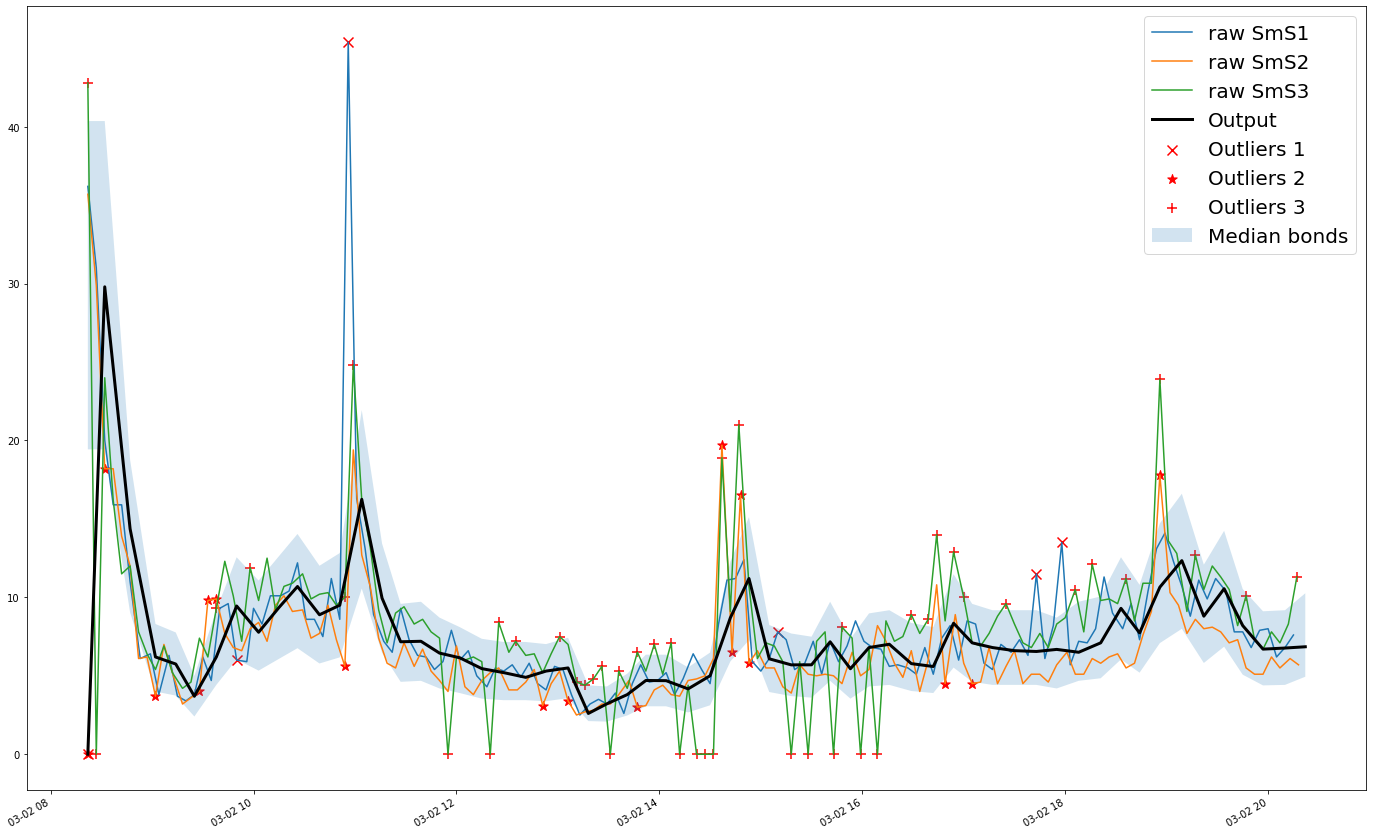

In [86]:
# Sizes of series for confidance index 
print('SmS1:',len(X1out),'errors /',len(X1raw),'points')
print('SmS2:',len(X2out),'errors /',len(X2raw),'points')
print('SmS3:',len(X3out),'errors /',len(X3raw),'points')
print('Steptime : ', tau , 'minutes')
print('Threshold', Threshold , '%')
# graphics series

plt.figure(figsize=(24,16))
plt.scatter(X1out.index, X1out.values,label='Outliers 1', s=100, c='red' ,marker = 'x')
plt.scatter(X2out.index, X2out.values,label='Outliers 2', s=100, c='red' ,marker = '*')
plt.scatter(X3out.index, X3out.values,label='Outliers 3', s=100, c='red' ,marker = '+')
X1raw.plot(label='raw SmS1')
X2raw.plot(label='raw SmS2')
X3raw.plot(label='raw SmS3')
plt.fill_between(Median.index,Median['MedMax'],Median['MedMin'],alpha = 0.2, label='Median bonds')
Outagg.plot(label='Output', linewidth = 3, c='black' )
# t=10
# plt.title('Th=50 and tau=%i' %t)
plt.legend(fontsize=20)
plt.show()